In [1]:
import opendssdirect as dss
import os
import pathlib
import numpy as np
import pandas as pd
import random
import sys
from scipy.stats import *
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import seaborn as sns
import math
from matplotlib.animation import FuncAnimation
from celluloid import Camera
import pytictoc
from pytictoc import TicToc
from datetime import datetime, timedelta

In [2]:
def loadchange(t):
    allLoad_name = dss.Loads.AllNames()
    i=0
    #lratio = 1
    lratio = loadshape[t]
    
    dss.Loads.First()
    while True:
        Pi = Pini[i]
        Qi = Qini[i]
        dss.run_command("Load."+allLoad_name[i]+".kW="+str(Pi*lratio))
        dss.run_command("Load."+allLoad_name[i]+".kvar="+str(Qi*lratio))
        i=i+1
        if not dss.Loads.Next() > 0:
            break
    return Pini, Qini

def pvchange(t):
    allpv_name = dss.PVsystems.AllNames()
    i=0
    #lratio = 1
    pvratio = pvshape[t]
    dss.PVsystems.First()

    while True:
        Pi = dss.PVsystems.kVARated()
        
        dss.run_command("PVSystem."+allpv_name[i]+".Pmpp="+str(Pi*pvratio))
        #print(Pi, Pi*pvratio)
        #dss.run_command("Load."+allLoad_name[i]+".kvar="+str(Qi*lratio))
        i=i+1
        if not dss.PVsystems.Next() > 0:
            break
            
def VTextract(Vthetmatrix):
    Vmat = np.zeros((Vthetmatrix.shape[0],3))
    Tmat = np.zeros((Vthetmatrix.shape[0],3))
    dis = np.zeros((Vthetmatrix.shape[0],3), dtype=int)
    for i in range(Vthetmatrix.shape[0]):
        for j in range(3):
            Vmat[i,j] = Vthetmatrix.iloc[i,4*j+3]
            Tmat[i,j] = Vthetmatrix.iloc[i,4*j+4]*np.pi/180
            if Vmat[i,j]!=0:
                dis[i,j]=1
    Vm = np.zeros(np.sum(dis))
    Tm = np.zeros(np.sum(dis))
    ena = 0
    for a in range(Vthetmatrix.shape[0]):
        for b in range(3):
            if dis[a,b]==1:
                Vm[ena]=Vmat[a,b]
                Tm[ena]=Tmat[a,b]
                ena = ena+1             
    return ena, Vm, Tm

def Sensecalc(ena, Vm, Tm):
    j1 = np.zeros((ena,ena))
    j2 = np.zeros((ena,ena))
    j3 = np.zeros((ena,ena))
    j4 = np.zeros((ena,ena))

    for a in range(ena):
        for b in range(ena):
            if a!=b:
                j1[a,b]=Vm[a]*Vm[b]*(Gm[a,b]*np.sin(Tm[a]-Tm[b])-Bm[a,b]*np.cos(Tm[a]-Tm[b]))
                j2[a,b]=Vm[a]*(Gm[a,b]*np.cos(Tm[a]-Tm[b])+Bm[a,b]*np.sin(Tm[a]-Tm[b]))
                j3[a,b]=-Vm[a]*Vm[b]*(Gm[a,b]*np.cos(Tm[a]-Tm[b])+Bm[a,b]*np.sin(Tm[a]-Tm[b]))
                j4[a,b]=Vm[a]*(Gm[a,b]*np.sin(Tm[a]-Tm[b])-Bm[a,b]*np.cos(Tm[a]-Tm[b]))
            if a==b:
                for c in range(ena):
                    if c!=a:
                        j1[a,b]=j1[a,b]-Vm[a]*Vm[c]*(Gm[a,c]*np.sin(Tm[a]-Tm[c])-Bm[a,c]*np.cos(Tm[a]-Tm[c]))
                        j2[a,b]=j2[a,b]+Vm[c]*(Gm[a,c]*np.cos(Tm[a]-Tm[c])+Bm[a,c]*np.sin(Tm[a]-Tm[c]))
                        j3[a,b]=j3[a,b]+Vm[a]*Vm[c]*(Gm[a,c]*np.cos(Tm[a]-Tm[c])+Bm[a,c]*np.sin(Tm[a]-Tm[c]))
                        j4[a,b]=j4[a,b]+Vm[c]*(Gm[a,c]*np.sin(Tm[a]-Tm[c])-Bm[a,c]*np.cos(Tm[a]-Tm[c]))
                    if c==a:
                        j2[a,b]=j2[a,b]+2*Vm[a]*Gm[a,b]
                        j4[a,b]=j4[a,b]-2*Vm[a]*Bm[a,b]                 
            if a<3 and b<3:
                j1[a,b]=0
                j2[a,b]=0
                j3[a,b]=0
                j4[a,b]=0      

    svq=np.linalg.inv(j4-np.matmul(j3,np.matmul(np.linalg.pinv(j1),j2)))
    svp=np.linalg.inv(j2-np.matmul(j1,np.matmul(np.linalg.pinv(j3),j4)))
    return svp, svq
            
def checkvoltage(Vm):
    V2pu = np.array(Vm)
    for i in range(len(V2pu)):
        if V2pu[i]*np.sqrt(3)>60000:
            V2pu[i] = Vm[i]/69000*np.sqrt(3)
        elif V2pu[i]*np.sqrt(3)>20000:
            V2pu[i] = Vm[i]/24900*np.sqrt(3)
        else:
            V2pu[i] = Vm[i]/4160*np.sqrt(3)

    V2vio_u = (V2pu[3:]-uv>0)
    V2vio_l = (V2pu[3:]-lv<0)
    vio_node = V2vio_u+V2vio_l
    return vio_node, V2pu

In [3]:
dss.__version__
dss.run_command('Redirect C:/Users/smartgrid_AI/Documents/kms/Hyundai/IEEE34BUSSYSTEM/ieee34Mod22.dss')
dss.run_command("New Energymeter.M1  Line.L1  1")

''

In [4]:
dss.Solution.Solve()
Ymatrixori = dss.Circuit.SystemY()
Ymatrix = np.array(Ymatrixori).reshape(138,-1)
Gm = Ymatrix[:, 0::2]
Bm = Ymatrix[:, 1::2]
Gm.shape

(138, 138)

In [5]:
satloadshape = np.loadtxt("SaturdayLoad.txt")*1.5
sunloadshape = np.loadtxt("SundayLoad.txt")*1.8
wkloadshape = np.loadtxt("WeekdayLoad.txt")*1.25

pvshape = np.loadtxt("PVshape.txt")
pvshape = pvshape/max(pvshape)
pvshape = np.concatenate((pvshape, pvshape, pvshape), axis=0)
loadshape = np.concatenate((wkloadshape, satloadshape, sunloadshape), axis=0)
avgload = (np.mean(wkloadshape)*5+np.mean(satloadshape)+np.mean(sunloadshape))/7
loadshape = loadshape/avgload

In [6]:
start = "00:00"
last = "23:45"

start_date = datetime.strptime(start, "%H:%M")
last_date = datetime.strptime(last, "%H:%M")
df_date = []
while start_date <= last_date:
    dates = start_date.strftime("%H:%M")
    df_date.append(dates)
    start_date += timedelta(minutes=15)
df_dat = np.array(df_date)
df_date = np.concatenate((df_dat, df_dat, df_dat), axis=0)
nums = np.array(range(df_date.shape[0]))

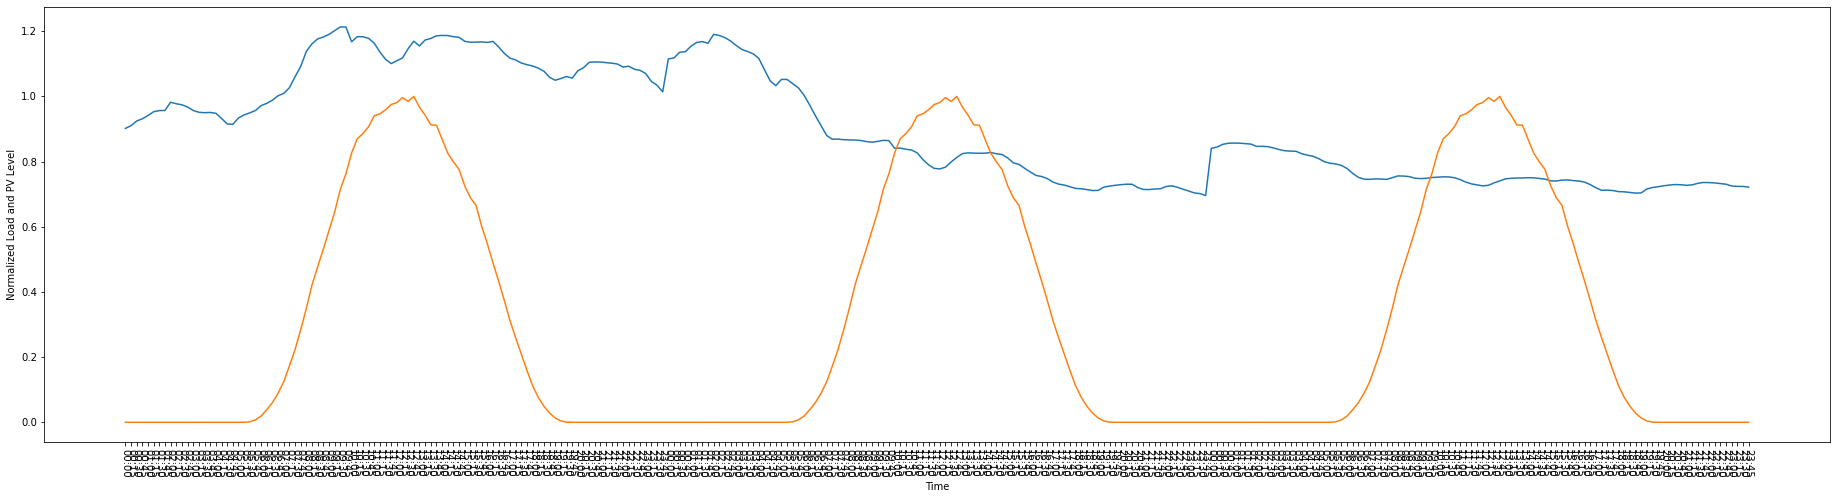

In [7]:
fig, ax = plt.subplots(figsize=(32, 8))

ax.plot(nums, loadshape)
ax.plot(nums, pvshape)
ax.set_xticks(nums)
ax.set_xticklabels(df_date)
plt.xticks(rotation = -90)
plt.xlabel("Time")
plt.ylabel("Normalized Load and PV Level")
plt.savefig("LoadPVCurve.png", dpi=1000)

In [8]:
allLoad_name = dss.Loads.AllNames()
i=0
dss.Loads.First()
Pini = np.zeros(np.array(allLoad_name).shape[0])
Qini = np.zeros(np.array(allLoad_name).shape[0])
while True:
    Pi = dss.Loads.kW()
    Qi = dss.Loads.kvar()
    Pini[i] = Pi
    Qini[i] = Qi
    i=i+1
    if not dss.Loads.Next() > 0:
        break

In [9]:
dss.Solution.Solve()
dss.run_command("export Voltages")
Vthetmatrix = pd.read_csv("ieee34-2_EXP_VOLTAGES.csv", encoding='CP949', error_bad_lines=False)
ena, Vm, Tm = VTextract(Vthetmatrix)
Vmini = Vm
#svp, svq = Sensecalc(ena, Vm, Tm)

In [10]:
pv_array= np.array([890, 828, 848, 840, 852])
pv_size = np.array([500, 200, 300, 200, 200]) 

num_pv = pv_array.shape[0]
pv_busind = np.zeros(num_pv, dtype=int)
nodelist = []
allnodename = dss.Circuit.AllNodeNames()
allnode = np.array(allnodename)

for i in range(num_pv):
    for j in range(1,4):
        x = np.where(allnode == str(pv_array[i])+'.'+str(j))[0][0]
        nodelist.append(x)
        
pvnodeind=np.array(nodelist, dtype=int)

for m in range(0,num_pv):
    if pv_array[m]!=0:
        if Vm[pvnodeind[3*m]]*np.sqrt(3)>50000:
            basekV = 69
        elif Vm[pvnodeind[3*m]]*np.sqrt(3)>15000:
            basekV = 24.9
        else:
            basekV = 4.16
        pv_kva_text="New PVSystem.PV"+str(m+1)+" conn=Wye phases=3 bus="+str(pv_array[m])+" kV="+str(basekV)+" irrad=1.0 Pmpp="+str(pv_size[m])+" temperature=25 kVA="+str(pv_size[m])+" WattPriority=True"
        print(pv_kva_text)
        dss.run_command(pv_kva_text)

New PVSystem.PV1 conn=Wye phases=3 bus=890 kV=4.16 irrad=1.0 Pmpp=500 temperature=25 kVA=500 WattPriority=True
New PVSystem.PV2 conn=Wye phases=3 bus=828 kV=24.9 irrad=1.0 Pmpp=200 temperature=25 kVA=200 WattPriority=True
New PVSystem.PV3 conn=Wye phases=3 bus=848 kV=24.9 irrad=1.0 Pmpp=300 temperature=25 kVA=300 WattPriority=True
New PVSystem.PV4 conn=Wye phases=3 bus=840 kV=24.9 irrad=1.0 Pmpp=200 temperature=25 kVA=200 WattPriority=True
New PVSystem.PV5 conn=Wye phases=3 bus=852 kV=24.9 irrad=1.0 Pmpp=200 temperature=25 kVA=200 WattPriority=True


In [11]:
dss.utils.pvsystems_to_dataframe()

,Irradiance,Name,pf,RegisterNames,RegisterValues,Idx,kVARated,kW,kvar,IrradianceNow,Pmpp,daily,duty,yearly,Tdaily,Tduty,Tyearly
pv1,1,pv1,1,"[kWh, kvarh, Max kW, Max kVA, Hours, Price($)]","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0]",1,500,500,0,1,500,,,,,,
pv2,1,pv2,1,"[kWh, kvarh, Max kW, Max kVA, Hours, Price($)]","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0]",2,200,200,0,1,200,,,,,,
pv3,1,pv3,1,"[kWh, kvarh, Max kW, Max kVA, Hours, Price($)]","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0]",3,300,300,0,1,300,,,,,,
pv4,1,pv4,1,"[kWh, kvarh, Max kW, Max kVA, Hours, Price($)]","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0]",4,200,200,0,1,200,,,,,,
pv5,1,pv5,1,"[kWh, kvarh, Max kW, Max kVA, Hours, Price($)]","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0]",5,200,200,0,1,200,,,,,,


In [12]:
def PVOPTION():
    optnum = list(map(int, input('PV의 무효전력 제어 옵션을 입력하세요(0: P 출력 비례 제한, 1: 절대 제한, 2: 제한 없음): ')))
    if optnum[0]==0 or optnum[0]==1 or optnum[0]==2:
        optnum=optnum[0]
        if optnum==0:
            limiter = float(input('P 출력 대비 제한률을 입력하세요: '))
        elif optnum==1:
            limiter = float(input('정격 대비 제한률을 입력하세요: '))
        else:
            limiter = 1
    else:
        print('옵션 번호가 잘못 입력되었습니다')
        PVOPTION(pv_size)
    return optnum, limiter

optnum, limiter = PVOPTION()

PV의 무효전력 제어 옵션을 입력하세요(0: P 출력 비례 제한, 1: 절대 제한, 2: 제한 없음):  1
정격 대비 제한률을 입력하세요:  0.3


In [14]:
alltf_name = dss.Transformers.AllNames()
i=0
Tap_pos = []
dss.Transformers.First()
while True:
    Tap_pos.append(dss.Transformers.Tap())
    i=i+1
    if not dss.Transformers.Next() >0:
        break

In [15]:
uv = 1.05
lv = 0.92

In [16]:
loadchange(0)
pvchange(0)
nodebasekv = np.zeros(Vm.shape[0])
Vtime = np.zeros((138, pvshape.shape[0]))
alpha = 0.3
beta = 0.5

dss.Solution.Solve()
dss.run_command("export Voltages")
Vthetmatrix = pd.read_csv("ieee34-2_EXP_VOLTAGES.csv", encoding='CP949', error_bad_lines=False)
ena, Vm, Tm = VTextract(Vthetmatrix)
Vtime[:,0] = Vm
svp, svq = Sensecalc(ena, Vm, Tm)
Vtimepu = np.zeros((138, pvshape.shape[0]))
for k in range(pvshape.shape[0]):
    _, Vtimepu[:,k] = checkvoltage(Vtime[:,k])

for i in range(len(Vm)):
    if Vm[i]*np.sqrt(3)>60000:
        nodebasekv[i] = 69000/np.sqrt(3)
    elif Vm[i]*np.sqrt(3)>20000:
        nodebasekv[i] = 24900/np.sqrt(3)
    else:
        nodebasekv[i] = 4160/np.sqrt(3)

In [17]:
busmagpu = dss.Circuit.AllBusMagPu()
allnodename = dss.Circuit.AllNodeNames()

allnode = np.array(allnodename)
busmag = np.array(busmagpu)

BusXY = 'C:/Users/smartgrid_AI/Documents/kms/Hyundai/IEEE34BUSSYSTEM/IEEE34_BusXY.csv'
busposition = pd.read_csv(BusXY, encoding='CP949', header=None)
#BusVol = np.concatenate([allbus.reshape(-1,1), busmagpu3], axis=1)
busposition.iloc[19:, 1] = busposition.iloc[19:, 1] + 500
busposition.iloc[20:, 1] = busposition.iloc[20:, 1] + 200
busposition.iloc[23:, 1] = busposition.iloc[23:, 1] + 1000
allnodepos = np.zeros((allnode.shape[0], 2))
allnodelen = np.zeros(allnode.shape[0])
for i in range(3, allnode.shape[0]):
    #print(allnode[i])
    if allnode[i][:3] == 'mid':
        nodeind = np.where(allnode[i][3:6] == busposition.iloc[:,0])[0][0]
        allnodepos[i,:] = (np.array(busposition.iloc[nodeind])[1:]+np.array(busposition.iloc[nodeind-1])[1:])/2
    else:
        nodeind = np.where(allnode[i][:3] == busposition.iloc[:,0])[0][0]
        allnodepos[i, :] = np.array(busposition.iloc[nodeind])[1:]
        
    allnodelen[i] = np.sqrt(math.pow(allnodepos[i,0],2)+math.pow(allnodepos[i,1],2))

dss.Lines.First()
name, B1, B2 = list(), list(), list()

while True:
    a = dss.Lines.Name()
    b = dss.Lines.Bus1()
    c = dss.Lines.Bus2()
    b = b.replace('.1.2.3','')
    c = c.replace('.1.2.3','')
    name.append(a),
    B1.append(b),
    B2.append(c)
    if not dss.Lines.Next() > 0:
        break
        
        
inda, indb, indc = [], [], []

for i in range(allnode.shape[0]):
    if allnode[i][-1:] == '1':
        inda.append(i)
    elif allnode[i][-1:] == '2':
        indb.append(i)
    else:
        indc.append(i)
        
inda = np.array(inda)
indb = np.array(indb)
indc = np.array(indc)

In [18]:
def Qlimitation(pv_size, pvshape, optnum, limiter, t):
    # 0: P 출력 비례 제한, 1: 절대 제한, 2: 제한 없음
    spareq = np.sqrt(pow(pv_size, 2)-pow(pv_size*pvshape[t], 2))
    if optnum==0:
        qlimit = np.apply_along_axis(lambda a: np.min(a), 0, [pv_size*pvshape[t]*limiter, spareq])
    elif optnum==1:
        qlimit = np.apply_along_axis(lambda a: np.min(a), 0, [pv_size*limiter, spareq])
    else:
        qlimit = spareq
    return spareq, qlimit

def rk_initialization(popn, dim, lb, ub):
    x = np.zeros((popn, dim), dtype=int)
    for i in range(dim):
        try:
            x[:,i] = np.random.randint(lb[i], ub[i], size=(popn))
        except:
            x[:,i] = 0
    return x

def pvqchange(qpos):
    allpv_name = dss.PVsystems.AllNames()
    a=0

    dss.PVsystems.First()

    while True:
        dss.run_command("PVSystem."+allpv_name[a]+".kvar="+str(qpos[a]))
        #print(Pi, Pi*pvratio)
        #dss.run_command("Load."+allLoad_name[i]+".kvar="+str(Qi*lratio))
        a=a+1
        if not dss.PVsystems.Next() > 0:
            break
               
def voltage_estim(volt, svq_pv, qoutput):
    PVnode = np.zeros(3*(qoutput.shape[1]), dtype=float)
    for i in range(qoutput.shape[1]):
        PVnode[3*i:3*i+3] = qoutput[0,i]/3
    #print(x.shape,PVpnode.shape)
    Vnew = volt+1000*np.matmul(svq_pv,PVnode)
    
    
    _, Vnewpu = checkvoltage(Vnew)
    
    uv_vio = Vnewpu-(uv-0.005)
    lv_vio = Vnewpu-(lv+0.005)
    uv_vio[0:15]=0
    delvpu = np.multiply(uv_vio,(uv_vio>0))+np.multiply(lv_vio, lv_vio<0)
    delv = np.multiply(delvpu, nodebasekv)
    
    return delv
    
def obj_rpc(delv, qoutput, qlimit):
    # Voltage security
    insecure = sum(abs(delv))>0
    f1 = insecure*1e18
    
    # Voltage insecurity level
    f2 = sum(abs(delv))*1e8
    
    # Reactive Power Usage Amount
    f3 = sum(sum(abs(qoutput)))
    
    # Spare Q Percentage
    f4 = max(max(abs(qoutput)/qlimit))*1e3
    
    return f1+f2+f3+f4

def rcostcheck(qpos):
    pvqchange(qpos)
    
    dss.Solution.Solve()
    dss.run_command("export Voltages")
    Vthetmatrix = pd.read_csv("ieee34-2_EXP_VOLTAGES.csv", encoding='CP949', error_bad_lines=False)
    ena, Vm, Tm = VTextract(Vthetmatrix)

    _, Vmpu = checkvoltage(Vm)
    uv_vio = Vmpu-(uv-0.005)
    lv_vio = Vmpu-(lv+0.005)
    uv_vio[0:15]=0
    delvpu = np.multiply(uv_vio,(uv_vio>0))+np.multiply(lv_vio, lv_vio<0)
    delv = np.multiply(delvpu, nodebasekv)

    insecure = sum(abs(delv))>0
    f1 = insecure*1e18
    f2 = sum(abs(delv))*1e8
    f3 = sum(abs(qpos))
    f4 = max(abs(qpos)/qlimit)*1e3
    rcost = f1+f2+f3+f4
    return rcost

def RungeKutta(Xb, Xw, DelX):
    dim = Xb.shape[1]
    C = (np.random.randint(2)+1)*(1-np.random.rand(1))
    r1 = np.random.rand(1, dim)
    r2 = np.random.rand(1, dim)
    
    K1 = 0.5*(np.random.rand(1)*Xw - C*Xb)
    K2 = 0.5*(np.random.rand(1)*(Xw+r2*np.multiply(K1, DelX)/2) - (C*Xb+r1*np.multiply(K1, DelX)/2))
    K3 = 0.5*(np.random.rand(1)*(Xw+r2*np.multiply(K2, DelX)/2) - (C*Xb+r1*np.multiply(K2, DelX)/2))
    K4 = 0.5*(np.random.rand(1)*(Xw+r2*np.multiply(K3, DelX)) - (C*Xb+r1*np.multiply(K3, DelX)))
    
    XRK = (K1+2*K2+2*K3+K4)
    SM = XRK/6
    return SM

def RndX(popn,i):
    Qi = np.random.permutation(popn)
    Qi = np.delete(Qi, np.where(Qi==i)[0][0])
    A = Qi[0]
    B = Qi[1]
    C = Qi[2]
    return A, B, C

def Unifrnd(a,b,c,dim):
    a2 = a/2
    b2 = b/2
    mu = a2+b2
    sig = b2-a2
    z = mu+sig*(2*np.random.rand(c,dim)-1)
    return z

def voltageprofile(vpu, save=""):
    sns.set(style = "whitegrid")
    fig = plt.figure(figsize=(36, 12))

    for i in range(1,inda.shape[0]):
        if (vpu[inda[i]]<uv-0.005 and vpu[inda[i]]>lv+0.005) or i<5:
            plt.scatter(allnodelen[inda[i]], vpu[inda[i]], c='black', s=10)
            if allnode[inda[i]][0] != 'm':
                plt.text(allnodelen[inda[i]]-25, vpu[inda[i]]-0.003, allnode[inda[i]][:3])
        else:
            plt.scatter(allnodelen[inda[i]], vpu[inda[i]], c='black', alpha=0.7, s=200, marker='*')
            if allnode[inda[i]][0] != 'm':
                plt.text(allnodelen[inda[i]]-25, vpu[inda[i]]-0.003, allnode[inda[i]][:3], color='red', weight="bold")
        
            
    for i in range(1,indb.shape[0]):
        if (vpu[indb[i]]<uv-0.005 and vpu[indb[i]]>lv+0.005) or i<5:
            plt.scatter(allnodelen[indb[i]], vpu[indb[i]], c='red', s=10)
        else:
            plt.scatter(allnodelen[indb[i]], vpu[indb[i]], c='red', alpha=0.7, s=200, marker='*')
            
    for i in range(1,indc.shape[0]):    
        if (vpu[indc[i]]<uv-0.005 and vpu[indc[i]]>lv+0.005) or i<5:
            plt.scatter(allnodelen[indc[i]], vpu[indc[i]], c='blue', s=10)
        else:
            plt.scatter(allnodelen[indc[i]], vpu[indc[i]], c='blue', alpha=0.7, s=200, marker='*')

    for i in range(len(B1)):
        if B1[i][-2:] == '.1':
            ind1 = np.where(B1[i]==allnode[inda])[0][0]
            ind2 = np.where(B2[i]==allnode[inda])[0][0]
            plt.plot([allnodelen[inda][ind1], allnodelen[inda][ind2]], [vpu[inda][ind1], vpu[inda][ind2]], c='black', linewidth=1.2)
        elif B1[i][-2:] == '.2':
            ind1 = np.where(B1[i]==allnode[indb])[0][0]
            ind2 = np.where(B2[i]==allnode[indb])[0][0]
            plt.plot([allnodelen[indb][ind1], allnodelen[indb][ind2]], [vpu[indb][ind1], vpu[indb][ind2]], c='red', linewidth=1.2)
        elif B1[i][-2:] == '.3':
            ind1 = np.where(B1[i]==allnode[indc])[0][0]
            ind2 = np.where(B2[i]==allnode[indc])[0][0]
            plt.plot([allnodelen[indc][ind1], allnodelen[indc][ind2]], [vpu[indc][ind1], vpu[indc][ind2]], c='blue', linewidth=1.2)
        else:
            ind1 = np.where(allnode[inda]==B1[i]+'.1')[0][0]
            ind2 = np.where(allnode[inda]==B2[i]+'.1')[0][0]
            plt.plot([allnodelen[inda][ind1], allnodelen[inda][ind2]], [vpu[inda][ind1], vpu[inda][ind2]], c='black', linewidth=1.2)
            ind1 = np.where(allnode[indb]==B1[i]+'.2')[0][0]
            ind2 = np.where(allnode[indb]==B2[i]+'.2')[0][0]
            plt.plot([allnodelen[indb][ind1], allnodelen[indb][ind2]], [vpu[indb][ind1], vpu[indb][ind2]], c='red', linewidth=1.2)
            ind1 = np.where(allnode[indc]==B1[i]+'.3')[0][0]
            ind2 = np.where(allnode[indc]==B2[i]+'.3')[0][0]
            plt.plot([allnodelen[indc][ind1], allnodelen[indc][ind2]], [vpu[indc][ind1], vpu[indc][ind2]], c='blue', linewidth=1.2)

    plt.hlines(lv, 0, 8000, colors='red', linewidth=3)
    plt.hlines(uv, 0, 8000, colors='red', linewidth=3)
    plt.hlines(lv+0.005, 0, 8000, colors='red', linewidth=1)
    plt.hlines(uv-0.005, 0, 8000, colors='red', linewidth=1)
    
    if save != "":
        plt.savefig(save+".png", dpi=1000)
    else:
        print("Fig name is not given.")
        
    plt.show()
    
def prandomize_apc(popn, ub, lb, dim):
    x = np.zeros((popn, dim), dtype=int)
    
    for i in range(dim):
        x[:,i] = np.random.rand(popn)*(ub[i]-lb[i])+lb[i]
        
    return x

def Qlimit_apc(optnum, xp, pv_size, limiter):
    spareq_apc = np.sqrt(pow(pv_size, 2)-pow(xp, 2))

    if optnum==0:
        qlimit = np.apply_along_axis(lambda a: np.min(a), 0, [xp*limiter, spareq_apc])
    elif optnum==1:
        qlimit = np.apply_along_axis(lambda a: np.min(a), 0, [pv_size*limiter, spareq_apc])
    else:
        qlimit = spareq_apc
    return spareq_apc, qlimit

def qrandomize_apc(qlimit, qratio=1):
    x = np.zeros(qlimit.shape)
    for i in range(qlimit.shape[1]):
        x[:,i] = np.random.rand(qlimit.shape[0])*(qlimit[:,i]*2)-qlimit[:,i]
    x = x*qratio        
    return x

def pvpchange(ppos):
    allpv_name = dss.PVsystems.AllNames()
    a=0

    dss.PVsystems.First()

    while True:
        dss.run_command("PVSystem."+allpv_name[a]+".Pmpp="+str(ppos[a]))
        a=a+1
        if not dss.PVsystems.Next() > 0:
            break

def obj_apc(delv, ppos, qpos, pini, qlimit):
    # Voltage security
    insecure = sum(abs(delv))>0
    f1 = insecure*1e18
    
    # Voltage insecurity level
    f2 = sum(abs(delv))*1e12
    
    # Active Power Curtailment Amount
    f3 = sum(sum(-ppos+pini))*1e6
    
    # Reactive Power Usage Amount
    f4 = sum(sum(abs(qpos)))
    
    # Spare Q Percentage
    f5 = max(max(abs(qpos)/qlimit))*1e3
    
    return f1+f2+f3+f4+f5

def rcostcheck_apc(ppos, qpos, pini, qlimit):
    pvpchange(ppos)
    pvqchange(qpos)
    
    dss.Solution.Solve()
    dss.run_command("export Voltages")
    Vthetmatrix = pd.read_csv("ieee34-2_EXP_VOLTAGES.csv", encoding='CP949', error_bad_lines=False)
    ena, Vm, Tm = VTextract(Vthetmatrix)

    _, Vmpu = checkvoltage(Vm)
    uv_vio = Vmpu-(uv-0.005)
    lv_vio = Vmpu-(lv+0.005)
    uv_vio[0:15]=0
    delvpu = np.multiply(uv_vio,(uv_vio>0))+np.multiply(lv_vio, lv_vio<0)
    delv = np.multiply(delvpu, nodebasekv)

    insecure = sum(abs(delv))>0
    f1 = insecure*1e18
    f2 = sum(abs(delv))*1e12
    f3 = sum(pini-ppos)*1e6
    f4 = sum(abs(qpos))
    f5 = max(abs(qpos)/qlimit)*1e3
    rcost = f1+f2+f3+f4+f5
    return rcost

def voltage_estim_apc(volt, svq_pv, svp_pv, qpos, ppos):
    PVnodep = np.zeros(3*(qpos.shape[1]), dtype=float)
    PVnodeq = np.zeros(3*(qpos.shape[1]), dtype=float)
    for i in range(qpos.shape[1]):
        PVnodep[3*i:3*i+3] = ppos[0,i]/3
        PVnodep[3*i:3*i+3] = qpos[0,i]/3
    #print(x.shape,PVpnode.shape)
    Vnew = volt+1000*np.matmul(svp_pv,PVnodep)+1000*np.matmul(svq_pv,PVnodeq)
    
    _, Vnewpu = checkvoltage(Vnew)
    
    uv_vio = Vnewpu-(uv-0.005)
    lv_vio = Vnewpu-(lv+0.005)
    uv_vio[0:15]=0
    delvpu = np.multiply(uv_vio,(uv_vio>0))+np.multiply(lv_vio, lv_vio<0)
    delv = np.multiply(delvpu, nodebasekv)
    
    return delv

In [19]:
def directAPC(svqinter, qlimnode, delv):
    vavail = np.matmul(svqinter, qlimnode)
    if sum(np.matmul(svqinter, qlimnode)*1000>delv[delv!=0])==svq_inter.shape[0]:
        direct = 0
    else:
        direct = 1
        
    return direct

def noAPC(delv, optnum):
    if sum(delv<0)>0 and optnum != 2:
        noAPC = 1
    else:
        noAPC = 0
    return noAPC

In [20]:
def rcostcheck_vu(qpos, vufactor):
    pvqchange(qpos)
    
    dss.Solution.Solve()
    dss.run_command("export Voltages")
    Vthetmatrix = pd.read_csv("ieee34-2_EXP_VOLTAGES.csv", encoding='CP949', error_bad_lines=False)
    ena, Vm, Tm = VTextract(Vthetmatrix)

    _, Vmpu = checkvoltage(Vm)
    uv_vio = Vmpu-(uv-0.005)
    lv_vio = Vmpu-(lv+0.005)
    uv_vio[0:15]=0
    delvpu = np.multiply(uv_vio,(uv_vio>0))+np.multiply(lv_vio, lv_vio<0)
    delv = np.multiply(delvpu, nodebasekv)

    insecure = sum(abs(delv))>0
    
    voltavg = np.mean(Vmpu)
    pvur = abs((Vmpu-voltavg)/voltavg*100)
    
    f1 = insecure*1e18
    f2 = sum(abs(delv))*1e8
    f3 = max(pvur[pvur>vufactor])*1e3
    f4 = max(abs(qpos)/qlimit)
    rcost = f1+f2+f3+f4
    return rcost

def vu_estim(volt, svq_pv, qoutput):
    PVnode = np.zeros(3*(qoutput.shape[1]), dtype=float)
    for i in range(qoutput.shape[1]):
        PVnode[3*i:3*i+3] = qoutput[0,i]/3
    #print(x.shape,PVpnode.shape)
    Vnew = volt+1000*np.matmul(svq_pv,PVnode)
    
    _, Vnewpu = checkvoltage(Vnew)
    
    uv_vio = Vnewpu-(uv-0.005)
    lv_vio = Vnewpu-(lv+0.005)
    uv_vio[0:15]=0
    delvpu = np.multiply(uv_vio,(uv_vio>0))+np.multiply(lv_vio, lv_vio<0)
    delv = np.multiply(delvpu, nodebasekv)
    
    return Vnewpu, delv

In [21]:
vufactor = 5 ## Voltage Unbalance Limitation: 5%

At Friday 0:0, Initial PVUR is 8.309506846161916%


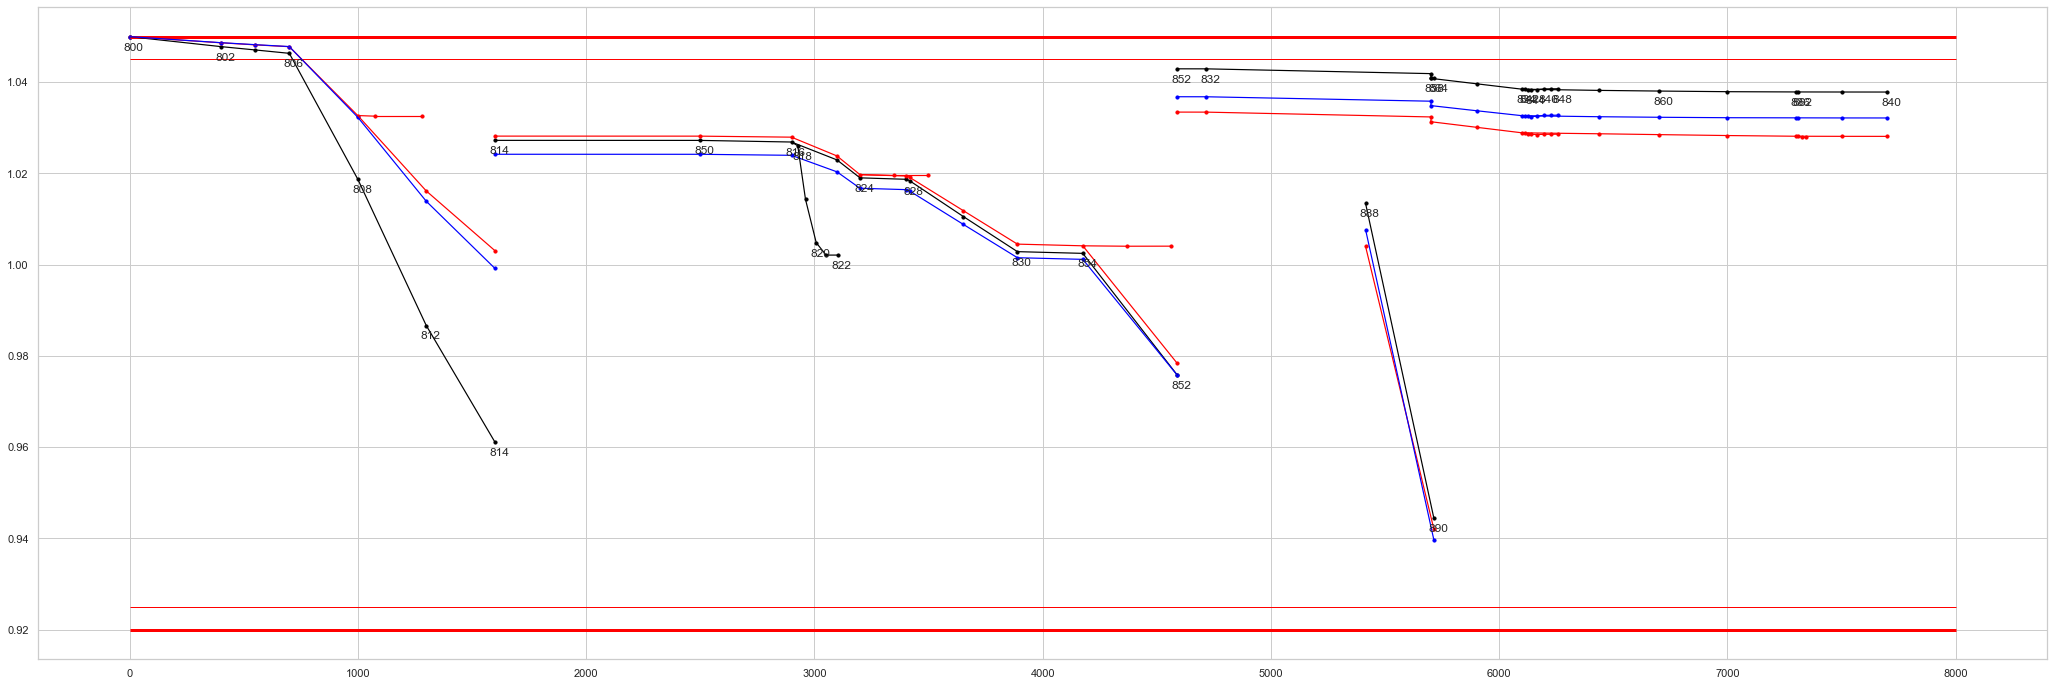

At iteration 10, the best cost is 6209.912423415425 with the positions: [[150.          60.         -90.         -53.04683489 -37.3460358 ]]
At iteration 20, the best cost is 6209.912423415425 with the positions: [[150.          60.         -90.         -53.04683489 -37.3460358 ]]
At iteration 30, the best cost is 6209.912423415425 with the positions: [[150.          60.         -90.         -53.04683489 -37.3460358 ]]


In [ ]:
from pytictoc import TicToc
tt=TicToc()
Vtimepu = np.zeros((138, pvshape.shape[0]))
for time in range(pvshape.shape[0]):
    loadchange(time)
    pvchange(time)
    pvqchange(np.zeros(num_pv))
    dss.Solution.Solve()
    dss.run_command("export Voltages")
    Vthetmatrix = pd.read_csv("ieee34-2_EXP_VOLTAGES.csv", encoding='CP949', error_bad_lines=False)
    ena, Vm, Tm = VTextract(Vthetmatrix)
    Vtime[:,time] = Vm
    svp, svq = Sensecalc(ena, Vm, Tm)
    
    _, Vtimepu[:,time] = checkvoltage(Vtime[:,time])
    
    uv_vio = Vtimepu[:,time]-(uv-0.005)
    lv_vio = Vtimepu[:,time]-(lv+0.005)
    #uv_vio = Vtimepu[:,time]-(uv)
    #lv_vio = Vtimepu[:,time]-(lv)
    uv_vio[0:15]=0
    delvpu = np.multiply(uv_vio,(uv_vio>0))+np.multiply(lv_vio, lv_vio<0)
    delv = np.multiply(delvpu, nodebasekv)
    
    svq_inter = svq[delv!=0, :]
    svq_inter = svq_inter[:,pvnodeind]
    
    if time<95:
        day = 'Friday'
    elif time<96*2-1:
        day = 'Saturday'
    else:
        day = 'Sunday'
    afday = time%96
    hour = afday//4
    minute = afday%4*15

    if sum(delv>0)==0 and sum(delv<0)>0:
        type = 'Low'
    elif sum(delv>0)>0 and sum(delv<0)==0:
        type = 'High'
    elif sum(delv>0)>0 and sum(delv<0)>0:
        type = 'High and Low'
    else:
        type = 'No'
            
    if svq_inter.shape[0]==0: ## Voltage Violation Not Occur --> Voltage Unbalance Solution
        tt.tic()
        voltavg = np.mean(Vtimepu[:,time])
        pvur = (Vtimepu[:,time]-voltavg)/voltavg*100
        pvur_ini = max(abs(pvur))
        ub_node = np.where(abs(pvur)>vufactor)
        svq_pv = svq[:, pvnodeind]
        svq_vu = svq_pv[ub_node,:]
        
        print("At "+day+" "+str(hour)+":"+str(minute)+", "+"Initial PVUR is "+str(pvur_ini)+"%")
        
        if svq_vu.shape[0]==0:
            print("Don't need any control since PVUR is "+str(pvur_ini)+"%")
            
        else:
            voltageprofile(Vtimepu[:,time], day+'_'+str(hour)+"."+str(minute)+'_before control')
            MaxIt = 100
            popn = 300
            max_indure = 30
            voltini = Vtime[:,time]
            voltinipu = Vtimepu[:,time]
            spareq, qlimit = Qlimitation(pv_size, pvshape, optnum, limiter, time)
            qlimitnode = np.concatenate((qlimit.reshape(-1,1)/3, qlimit.reshape(-1,1)/3, qlimit.reshape(-1,1)/3), axis=1)
            qlimitnode = qlimitnode.reshape(-1)

            UB = qlimit
            LB = -qlimit

            X = rk_initialization(popn, num_pv, LB, UB)
            conv_curve = np.ones((1, MaxIt+1))*np.inf
            cost = np.zeros(popn)

            for pop in range(popn):
                cost[pop] = rcostcheck_vu(X[pop,:], vufactor)

            best_cost = np.min(cost)
            best_ind = np.argmin(cost)
            Best_X = X[best_ind,:]

            conv_curve[0,0] = best_cost

            update_check = 0
            for It in range(MaxIt):
                It = It+1
                f = 20*np.exp(-12*It/MaxIt)
                Xavg = np.mean(X, axis=0)
                SF = 2*0.5-np.random.rand(1,popn)*f

                for i in range(popn):
                    l_cost = np.min(cost)
                    l_ind = np.argmin(cost)
                    lbest = X[l_ind,:].reshape(1,-1)
                    A, B, C = RndX(popn, i)
                    ind1 = np.argmin(cost[[A,B,C]])

                    #print(X.shape, Best_X.shape, Xavg.shape)
                    gamma = np.random.rand(1)*(X[i,:]-np.random.rand(1,X.shape[1])*(UB-LB))*np.exp(-4*It/MaxIt)
                    Stp = np.random.rand(1,X.shape[1])*((Best_X - np.random.rand(1)*Xavg))
                    DelX = 2*np.multiply(np.random.rand(1,X.shape[1]),np.abs(Stp))

                    if cost[i]<cost[ind1]:
                        Xb = X[i,:].reshape(1,-1)
                        Xw = X[ind1,:].reshape(1,-1)
                    else:
                        Xb = X[ind1,:].reshape(1,-1)
                        Xw = X[i,:].reshape(1,-1)

                    SM = RungeKutta(Xb, Xw, DelX)

                    L = np.random.rand(1,X.shape[1])<0.5
                    Xc = np.multiply(L, X[i,:])+np.multiply(1-L,X[A,:])
                    Xm = np.multiply(L, Best_X)+np.multiply(1-L,lbest)

                    vec = np.array((1, -1))
                    flag = np.array(np.floor(2*np.random.rand(1,X.shape[1])), dtype=int)

                    r = vec[flag]

                    g = 2*np.random.rand(1)
                    mu = 0.5+np.random.randn(1,X.shape[1])*0.1

                    if np.random.rand(1)<0.5:
                        Xnew = (Xc + r*SF[0,i]*g*Xc) + SF[0,i]*SM + mu*(Xm-Xc)
                    else:
                        Xnew = (Xm + r*SF[0,i]*g*Xm) + SF[0,i]*SM + mu*(X[A,:]-X[B,:])

                    FU = Xnew>UB
                    FL = Xnew<LB
                    Xnew = np.multiply(Xnew, ~(FU+FL)) + np.multiply(UB, FU) + np.multiply(LB, FL)

                    CostNew = rcostcheck_vu(Xnew[0,:], vufactor)

                    if CostNew<cost[i]:
                        X[i,:] = Xnew
                        cost[i] = CostNew

                    if np.random.rand(1)<0.5:
                        EXP = np.exp(-5*np.random.rand(1)*It/MaxIt)
                        r = np.floor(Unifrnd(-1,2,1,1))
                        u = 2*np.random.rand(1,X.shape[1])
                        w = Unifrnd(0,2,1,X.shape[1])*EXP

                        A, B, C = RndX(popn, i)
                        Xavg = (X[A,:]+X[B,:]+X[C,:])/3

                        beta = np.random.rand(1,X.shape[1])
                        Xnew1 = beta*Best_X+(1-beta)*Xavg
                        Xnew2 = np.zeros(Xnew1.shape)
                        for j in range(X.shape[1]):
                            if w[0,j]<1:
                                Xnew2[0,j] = Xnew1[0,j]+r*w[0,j]*np.abs((Xnew1[0,j]-Xavg[j])+np.random.randn(1))
                            else:
                                Xnew2[0,j] = Xnew1[0,j]-Xavg[j]+r*w[0,j]*np.abs(np.multiply(u[0,j], Xnew1[0,j])-Xavg[j]+np.random.randn(1))

                        FU = Xnew2>UB
                        FL = Xnew2<LB

                        Xnew2 = np.multiply(Xnew2, ~(FU+FL)) + np.multiply(UB, FU) + np.multiply(LB, FL)

                        CostNew = rcostcheck_vu(Xnew2[0,:], vufactor)

                        if CostNew<cost[i]:
                            X[i,:] = Xnew2
                            cost[i] = CostNew
                        else:
                            if np.random.rand(1)<w[0,np.random.randint(X.shape[1])]:
                                SM = RungeKutta(X[i,:].reshape(1,-1), Xnew2, DelX)
                                Xnew = (Xnew2-np.random.rand(1)*Xnew2) + SF[0,i]*(SM+2*np.multiply(np.random.rand(1,X.shape[1]),Best_X)-Xnew2)
                                FU = Xnew>UB
                                FL = Xnew<LB
                                Xnew = np.multiply(Xnew, ~(FU+FL)) + np.multiply(UB, FU) + np.multiply(LB, FL)

                                CostNew = rcostcheck_vu(Xnew[0,:], vufactor)

                                if CostNew<cost[i]:
                                    X[i,:] = Xnew
                                    cost[i] = CostNew

                        if cost[i]<best_cost:
                            #print("Real cost check with "+str(Xnew))
                            rcost = rcostcheck_vu(Xnew[0,:], vufactor)
                            if rcost < best_cost:
                                best_cost = rcost
                                Best_X = Xnew

                                if rcost < 1e4:
                                    qratio_re = max(abs(Xnew/qlimit))
                                    X = rk_initialization(popn, num_pv, LB*qratio_re, UB*qratio_re)
                                else:
                                    X = rk_initialization(popn, num_pv, LB, UB)                       
                                Xavg = np.mean(X, axis=0)

                conv_curve[0,It] = best_cost

                if It>1:
                    if conv_curve[0,It] < min(conv_curve[0,0:It-1]):
                        update_check = 0
                    else:
                        update_check = update_check+1
                        if update_check > max_indure:
                            break        
                #print("At iter "+str(It)+" "+str(update_check)+" with cost "+str(best_cost))
                if It%10 == 0:
                    print("At iteration "+str(It)+", the best cost is "+str(best_cost)+" with the positions: "+str(Best_X))


            pvqchange(Best_X.reshape(-1,1))

            dss.Solution.Solve()
            dss.run_command("export Voltages")
            Vthetmatrix = pd.read_csv("ieee34-2_EXP_VOLTAGES.csv", encoding='CP949', error_bad_lines=False)
            ena, Vm, Tm = VTextract(Vthetmatrix)

            _, Vmpu = checkvoltage(Vm)
            voltavg = np.mean(Vmpu)
            pvur = abs((Vmpu-voltavg)/voltavg*100)

            print("The best reactive power control position is "+str(Best_X)+" with PVUR Change from "+str(pvur_ini)+" to "+str(max(pvur))+"%")
            voltageprofile(Vmpu, day+'.'+str(hour)+"."+str(minute)+'_after VU control')
            tt.toc()            

    else: ## Voltage Violation Case 
        print("At "+day+" "+str(hour)+":"+str(minute)+", " +type+" Voltage Violation Occured")
        
        tt.tic()
        
        voltini = Vtime[:,time]
        voltinipu = Vtimepu[:,time]
        svq_pv = svq[:,pvnodeind]
        voltageprofile(voltinipu, day+'_'+str(hour)+"."+str(minute)+'_before control')
        
        spareq, qlimit = Qlimitation(pv_size, pvshape, optnum, limiter, time)
        qlimitnode = np.concatenate((qlimit.reshape(-1,1)/3, qlimit.reshape(-1,1)/3, qlimit.reshape(-1,1)/3), axis=1)
        qlimitnode = qlimitnode.reshape(-1)
        
        dir_APC = directAPC(svq_inter, qlimitnode, delv)
        
        MaxIt = 100
        popn = 300
        max_indure = 30

        UB = qlimit
        LB = -qlimit
        
        if dir_APC == 0:
            X = rk_initialization(popn, num_pv, LB, UB)
            conv_curve = np.ones((1, MaxIt+1))*np.inf
            cost = np.zeros(popn)

            for pop in range(popn):
                cost[pop] = rcostcheck(X[pop,:])

            best_cost = np.min(cost)
            best_ind = np.argmin(cost)
            Best_X = X[best_ind,:]

            conv_curve[0,0] = best_cost

            update_check = 0
            for It in range(MaxIt):
                It = It+1
                f = 20*np.exp(-12*It/MaxIt)
                Xavg = np.mean(X, axis=0)
                SF = 2*0.5-np.random.rand(1,popn)*f

                for i in range(popn):
                    l_cost = np.min(cost)
                    l_ind = np.argmin(cost)
                    lbest = X[l_ind,:].reshape(1,-1)
                    A, B, C = RndX(popn, i)
                    ind1 = np.argmin(cost[[A,B,C]])

                    #print(X.shape, Best_X.shape, Xavg.shape)
                    gamma = np.random.rand(1)*(X[i,:]-np.random.rand(1,X.shape[1])*(UB-LB))*np.exp(-4*It/MaxIt)
                    Stp = np.random.rand(1,X.shape[1])*((Best_X - np.random.rand(1)*Xavg))
                    DelX = 2*np.multiply(np.random.rand(1,X.shape[1]),np.abs(Stp))

                    if cost[i]<cost[ind1]:
                        Xb = X[i,:].reshape(1,-1)
                        Xw = X[ind1,:].reshape(1,-1)
                    else:
                        Xb = X[ind1,:].reshape(1,-1)
                        Xw = X[i,:].reshape(1,-1)

                    SM = RungeKutta(Xb, Xw, DelX)

                    L = np.random.rand(1,X.shape[1])<0.5
                    Xc = np.multiply(L, X[i,:])+np.multiply(1-L,X[A,:])
                    Xm = np.multiply(L, Best_X)+np.multiply(1-L,lbest)

                    vec = np.array((1, -1))
                    flag = np.array(np.floor(2*np.random.rand(1,X.shape[1])), dtype=int)

                    r = vec[flag]

                    g = 2*np.random.rand(1)
                    mu = 0.5+np.random.randn(1,X.shape[1])*0.1

                    if np.random.rand(1)<0.5:
                        Xnew = (Xc + r*SF[0,i]*g*Xc) + SF[0,i]*SM + mu*(Xm-Xc)
                    else:
                        Xnew = (Xm + r*SF[0,i]*g*Xm) + SF[0,i]*SM + mu*(X[A,:]-X[B,:])

                    FU = Xnew>UB
                    FL = Xnew<LB
                    Xnew = np.multiply(Xnew, ~(FU+FL)) + np.multiply(UB, FU) + np.multiply(LB, FL)

                    delv_estim = voltage_estim(voltini, svq_pv, Xnew)
                    CostNew = obj_rpc(delv_estim, Xnew, qlimit)
                    #CostNew = objfunction(Best_A, Xnew, uv, lv, svp_pv, Vm)

                    if CostNew<cost[i]:
                        X[i,:] = Xnew
                        cost[i] = CostNew

                    if np.random.rand(1)<0.5:
                        EXP = np.exp(-5*np.random.rand(1)*It/MaxIt)
                        r = np.floor(Unifrnd(-1,2,1,1))
                        u = 2*np.random.rand(1,X.shape[1])
                        w = Unifrnd(0,2,1,X.shape[1])*EXP

                        A, B, C = RndX(popn, i)
                        Xavg = (X[A,:]+X[B,:]+X[C,:])/3

                        beta = np.random.rand(1,X.shape[1])
                        Xnew1 = beta*Best_X+(1-beta)*Xavg
                        Xnew2 = np.zeros(Xnew1.shape)
                        for j in range(X.shape[1]):
                            if w[0,j]<1:
                                Xnew2[0,j] = Xnew1[0,j]+r*w[0,j]*np.abs((Xnew1[0,j]-Xavg[j])+np.random.randn(1))
                            else:
                                Xnew2[0,j] = Xnew1[0,j]-Xavg[j]+r*w[0,j]*np.abs(np.multiply(u[0,j], Xnew1[0,j])-Xavg[j]+np.random.randn(1))

                        FU = Xnew2>UB
                        FL = Xnew2<LB

                        Xnew2 = np.multiply(Xnew2, ~(FU+FL)) + np.multiply(UB, FU) + np.multiply(LB, FL)
                        delv_estim = voltage_estim(voltini, svq_pv, Xnew2)
                        CostNew = obj_rpc(delv_estim, Xnew2, qlimit)

                        if CostNew<cost[i]:
                            X[i,:] = Xnew2
                            cost[i] = CostNew
                        else:
                            if np.random.rand(1)<w[0,np.random.randint(X.shape[1])]:
                                SM = RungeKutta(X[i,:].reshape(1,-1), Xnew2, DelX)
                                Xnew = (Xnew2-np.random.rand(1)*Xnew2) + SF[0,i]*(SM+2*np.multiply(np.random.rand(1,X.shape[1]),Best_X)-Xnew2)
                                FU = Xnew>UB
                                FL = Xnew<LB
                                Xnew = np.multiply(Xnew, ~(FU+FL)) + np.multiply(UB, FU) + np.multiply(LB, FL)

                                delv_estim = voltage_estim(voltini, svq_pv, Xnew)
                                CostNew = obj_rpc(delv_estim, Xnew, qlimit)

                                if CostNew<cost[i]:
                                    X[i,:] = Xnew
                                    cost[i] = CostNew

                        if cost[i]<best_cost:
                            #print("Real cost check with "+str(Xnew))
                            rcost = rcostcheck(Xnew[0,:])
                            if rcost < best_cost:
                                best_cost = rcost
                                Best_X = Xnew

                                if rcost < 1e8:
                                    qratio_re = max(abs(Xnew/qlimit))
                                    X = rk_initialization(popn, num_pv, LB*qratio_re, UB*qratio_re)
                                else:
                                    X = rk_initialization(popn, num_pv, LB, UB)                       
                                Xavg = np.mean(X, axis=0)

                conv_curve[0,It] = best_cost

                if It>1:
                    if conv_curve[0,It] < min(conv_curve[0,0:It-1]):
                        update_check = 0
                    else:
                        update_check = update_check+1
                        if update_check > max_indure:
                            break        
                #print("At iter "+str(It)+" "+str(update_check)+" with cost "+str(best_cost))
                if It%10 == 0:
                    print("At iteration "+str(It)+", the best cost is "+str(best_cost)+" with the positions: "+str(Best_X))

            print("The best reactive power control position is "+str(Best_X)+" with objective function cost "+str(best_cost))

            pvqchange(Best_X.reshape(-1,1))

            dss.Solution.Solve()
            dss.run_command("export Voltages")
            Vthetmatrix = pd.read_csv("ieee34-2_EXP_VOLTAGES.csv", encoding='CP949', error_bad_lines=False)
            ena, Vm, Tm = VTextract(Vthetmatrix)

            _, Vmpu = checkvoltage(Vm)
            uv_vio = Vmpu-(uv-0.005)
            lv_vio = Vmpu-(lv+0.005)
            uv_vio2 = Vmpu-(uv)
            lv_vio2 = Vmpu-(lv)
            uv_vio[0:15]=0
            uv_vio2[0:15]=0
            delvpu = np.multiply(uv_vio,(uv_vio>0))+np.multiply(lv_vio, lv_vio<0)
            delv = np.multiply(delvpu, nodebasekv)

            delvpu2 = np.multiply(uv_vio2,(uv_vio2>0))+np.multiply(lv_vio2, lv_vio2<0)
            delv2 = np.multiply(delvpu2, nodebasekv)

            apc = 0

            if sum(abs(delv2))>0:
                print("APC is required")
                voltageprofile(Vmpu)
                apc = 1
            else:
                if sum(abs(delv))>0:
                    print("Voltage is stabilized but more reactive power is required")
                    voltageprofile(Vmpu, day+'.'+str(hour)+"."+str(minute)+'_after control')
                    tt.toc()
                else:
                    voltageprofile(Vmpu, day+'.'+str(hour)+"."+str(minute)+'_after control')
                    tt.toc()           
        else:
            print("RPC is skipped and directly goes to APC")
            apc = 1
            
        if apc == 1:
            if noAPC(delv, optnum) == 0:
                Pinit = pv_size*pvshape[time]
                pvpchange(Pinit)
                pvqchange(np.zeros(num_pv))

                conv_curve = np.ones((1, MaxIt+1))*np.inf
                cost = np.zeros(popn*2)
                svp_pv = svp[:,pvnodeind]

                xp = prandomize_apc(popn*2, Pinit, np.zeros(num_pv), num_pv)
                spareq_apc, qlimapc = np.zeros(xp.shape), np.zeros(xp.shape)

                for i in range(xp.shape[0]):
                    spareq_apc[i,:], qlimapc[i,:] = Qlimit_apc(optnum, xp[i,:], pv_size, limiter)

                xq = qrandomize_apc(qlimapc)

                for pop in range(popn*2):
                    cost[pop] = rcostcheck_apc(xp[pop,:], xq[pop,:], Pinit, qlimapc[i,:])

                best_cost = np.min(cost)
                best_ind = np.argmin(cost)
                Best_Xp = xp[best_ind,:]
                Best_Xq = xq[best_ind,:]
                conv_curve[0,0] = best_cost
                update_check = 0

                #print(Best_Xp.shape, Best_Xq.shape)

                for It in range(MaxIt):
                    It = It+1
                    f = 20*np.exp(-12*It/MaxIt)

                    Xpavg = np.mean(xp, axis=0)
                    Xqavg = np.mean(xq, axis=0)

                    SF = 2*0.5-np.random.rand(1,popn*2)*f

                    for i in range(popn*2):
                        l_cost = np.min(cost)
                        l_ind = np.argmin(cost)

                        lbestp = xp[l_ind,:].reshape(1,-1)
                        lbestq = xq[l_ind,:].reshape(1,-1)

                        A, B, C = RndX(popn*2, i)
                        ind1 = np.argmin(cost[[A,B,C]])

                        #print(X.shape, Best_X.shape, Xavg.shape)
                        gamma_p = np.random.rand(1)*(xp[i,:]-np.random.rand(1,xp.shape[1])*(pv_size*pvshape[time]))*np.exp(-4*It/MaxIt)
                        Stp_p = np.random.rand(1,xp.shape[1])*((Best_Xp - np.random.rand(1)*Xpavg))
                        DelXp = 2*np.multiply(np.random.rand(1,xp.shape[1]),np.abs(Stp_p))

                        gamma_q = np.random.rand(1)*(xq[i,:]-np.random.rand(1,xq.shape[1])*(qlimapc[i,:]*2))*np.exp(-4*It/MaxIt)
                        Stp_q = np.random.rand(1,xq.shape[1])*((Best_Xq - np.random.rand(1)*Xqavg))
                        DelXq = 2*np.multiply(np.random.rand(1,xq.shape[1]),np.abs(Stp_q))

                        if cost[i]<cost[ind1]:
                            Xbp = xp[i,:].reshape(1,-1)
                            Xwp = xp[ind1,:].reshape(1,-1)

                            Xbq = xq[i,:].reshape(1,-1)
                            Xwq = xq[ind1,:].reshape(1,-1)
                        else:
                            Xbp = xp[ind1,:].reshape(1,-1)
                            Xwp = xp[i,:].reshape(1,-1)

                            Xbq = xq[i,:].reshape(1,-1)
                            Xwq = xq[ind1,:].reshape(1,-1)

                        SMp = RungeKutta(Xbp, Xwp, DelXp)
                        SMq = RungeKutta(Xbq, Xwq, DelXq)

                        Lp = np.random.rand(1,xp.shape[1])<0.5
                        Xcp = np.multiply(Lp, xp[i,:])+np.multiply(1-Lp, xp[A,:])
                        Xmp = np.multiply(Lp, Best_Xp)+np.multiply(1-Lp,lbestp)

                        Lq = np.random.rand(1,xq.shape[1])<0.5
                        Xcq = np.multiply(Lq, xq[i,:])+np.multiply(1-Lq, xq[A,:])
                        Xmq = np.multiply(Lq, Best_Xq)+np.multiply(1-Lq,lbestq) 

                        vec = np.array((1, -1))
                        flagp = np.array(np.floor(2*np.random.rand(1,xp.shape[1])), dtype=int)
                        flagq = np.array(np.floor(2*np.random.rand(1,xq.shape[1])), dtype=int)

                        rp = vec[flagp]
                        rq = vec[flagq]

                        g = 2*np.random.rand(1)
                        mup = 0.5+np.random.randn(1,xp.shape[1])*0.1
                        muq = 0.5+np.random.randn(1,xq.shape[1])*0.1

                        if np.random.rand(1)<0.5:
                            Xnewp = (Xcp + rp*SF[0,i]*g*Xcp) + SF[0,i]*SMp + mup*(Xmp-Xcp)
                            Xnewq = (Xcq + rq*SF[0,i]*g*Xcq) + SF[0,i]*SMq + muq*(Xmq-Xcq)
                        else:
                            Xnewp = (Xmp + rp*SF[0,i]*g*Xmp) + SF[0,i]*SMp + mup*(xp[A,:]-xp[B,:])
                            Xnewq = (Xmq + rq*SF[0,i]*g*Xmq) + SF[0,i]*SMq + muq*(xq[A,:]-xq[B,:])

                        #print(Xnewp.shape, Xnewq.shape)

                        FU_p = Xnewp>pv_size*pvshape[time]
                        FL_p = Xnewp<0

                        FU_q = Xnewq>qlimapc[i,:]
                        FL_q = Xnewq<-qlimapc[i,:]

                        Xnewp = np.multiply(Xnewp, ~(FU_p+FL_p)) + np.multiply(pv_size*pvshape[time], FU_p) + np.multiply(0, FL_p)
                        Xnewq = np.multiply(Xnewq, ~(FU_q+FL_q)) + np.multiply(qlimapc[i,:], FU_q) + np.multiply(-qlimapc[i,:], FL_q)

                        delv_estim = voltage_estim_apc(voltini, svq_pv, svp_pv, Xnewq, Xnewp)
                        CostNew = obj_apc(delv_estim, Xnewp, Xnewq, Pinit, qlimapc[i,:])
                        #CostNew = objfunction(Best_A, Xnew, uv, lv, svp_pv, Vm)
                        #print(CostNew)
                        if CostNew<cost[i]:
                            xp[i,:] = Xnewp
                            xq[i,:] = Xnewq
                            cost[i] = CostNew

                        if np.random.rand(1)<0.5:
                            EXP = np.exp(-5*np.random.rand(1)*It/MaxIt)
                            r = np.floor(Unifrnd(-1,2,1,1))

                            u = 2*np.random.rand(1,xp.shape[1])
                            w = Unifrnd(0,2,1,xp.shape[1])*EXP

                            A, B, C = RndX(popn*2, i)
                            Xavgp = (xp[A,:]+xp[B,:]+xp[C,:])/3
                            Xavgq = (xq[A,:]+xq[B,:]+xq[C,:])/3

                            beta = np.random.rand(1,xp.shape[1])
                            Xnew1p = beta*Best_Xp+(1-beta)*Xavgp
                            Xnew2p = np.zeros(Xnew1p.shape)

                            Xnew1q = beta*Best_Xq+(1-beta)*Xavgq
                            Xnew2q = np.zeros(Xnew1q.shape)

                            for j in range(xp.shape[1]):
                                if w[0,j]<1:
                                    Xnew2p[0,j] = Xnew1p[0,j]+r*w[0,j]*np.abs((Xnew1p[0,j]-Xavgp[j])+np.random.randn(1))
                                    Xnew2q[0,j] = Xnew1q[0,j]+r*w[0,j]*np.abs((Xnew1q[0,j]-Xavgq[j])+np.random.randn(1))
                                else:
                                    Xnew2p[0,j] = Xnew1p[0,j]-Xavgp[j]+r*w[0,j]*np.abs(np.multiply(u[0,j], Xnew1p[0,j])-Xavgp[j]+np.random.randn(1))
                                    Xnew2q[0,j] = Xnew1q[0,j]-Xavgq[j]+r*w[0,j]*np.abs(np.multiply(u[0,j], Xnew1q[0,j])-Xavgq[j]+np.random.randn(1))

                            FU_p = Xnewp>pv_size*pvshape[time]
                            FL_p = Xnewp<0

                            FU_q = Xnewq>qlimapc[i,:]
                            FL_q = Xnewq<-qlimapc[i,:]

                            Xnew2p = np.multiply(Xnew2p, ~(FU_p+FL_p)) + np.multiply(pv_size*pvshape[time], FU_p) + np.multiply(0, FL_p)
                            Xnew2q = np.multiply(Xnew2q, ~(FU_q+FL_q)) + np.multiply(qlimapc[i,:], FU_q) + np.multiply(-qlimapc[i,:], FL_q)

                            delv_estim = voltage_estim_apc(voltini, svq_pv, svp_pv, Xnew2q, Xnew2p)
                            CostNew = obj_apc(delv_estim, Xnew2p, Xnew2q, Pinit, qlimapc[i,:])

                            if CostNew<cost[i]:
                                xp[i,:] = Xnew2p
                                xq[i,:] = Xnew2q
                                cost[i] = CostNew
                            else:
                                if np.random.rand(1)<w[0,np.random.randint(xp.shape[1])]:
                                    SMp = RungeKutta(xp[i,:].reshape(1,-1), Xnew2p, DelXp)
                                    Xnewp = (Xnew2p-np.random.rand(1)*Xnew2p) + SF[0,i]*(SMp+2*np.multiply(np.random.rand(1,xp.shape[1]),Best_Xp)-Xnew2p)
                                    SMq = RungeKutta(xq[i,:].reshape(1,-1), Xnew2q, DelXq)
                                    Xnewq = (Xnew2q-np.random.rand(1)*Xnew2q) + SF[0,i]*(SMq+2*np.multiply(np.random.rand(1,xq.shape[1]),Best_Xq)-Xnew2q)

                                    FU_p = Xnewp>pv_size*pvshape[time]
                                    FL_p = Xnewp<0

                                    FU_q = Xnewq>qlimapc[i,:]
                                    FL_q = Xnewq<-qlimapc[i,:]

                                    Xnewp = np.multiply(Xnewp, ~(FU_p+FL_p)) + np.multiply(pv_size*pvshape[time], FU_p) + np.multiply(0, FL_p)
                                    Xnewq = np.multiply(Xnewq, ~(FU_q+FL_q)) + np.multiply(qlimapc[i,:], FU_q) + np.multiply(-qlimapc[i,:], FL_q)

                                    delv_estim = voltage_estim_apc(voltini, svq_pv, svp_pv, Xnewq, Xnewp)
                                    CostNew = obj_apc(delv_estim, Xnewp, Xnewq, Pinit, qlimapc[i,:])

                                    if CostNew<cost[i]:
                                        xp[i,:] = Xnewp
                                        xq[i,:] = Xnewq
                                        cost[i] = CostNew

                            if (cost[i]<best_cost) or (cost[i]<1e18):
                                #print("Real cost check with "+str(Xnew))
                                #rcost = rcostcheck(Xnew[0,:])
                                rcost = rcostcheck_apc(Xnewp[0,:], Xnewq[0,:], Pinit, qlimapc[i,:])
                                if rcost < best_cost:
                                    best_cost = rcost
                                    Best_Xp = Xnewp[0,:]
                                    Best_Xq = Xnewq[0,:]

                                    if rcost < 1e12:
                                        qratio_re = max(max(abs(Xnewq/qlimapc[i,:])))
                                        xp = prandomize_apc(popn*2, Pinit, Xnewp[0,:]-Xnewp[0,:]*0.4, num_pv)
                                        qlimapc = np.zeros(xp.shape)
                                        spareqapc = np.zeros(xp.shape)

                                        for num in range(popn*2):
                                            spareqapc[num,:], qlimapc[num,:] = Qlimit_apc(optnum, xp[num,:], pv_size, limiter)

                                        xq = qrandomize_apc(qlimapc, qratio_re)
                                        #print("rcost 1e12"+str(xp.shape) +" "+ str(xq.shape))
                                    else:
                                        xp = prandomize_apc(popn*2, Pinit, np.zeros(num_pv), num_pv)   
                                        qlimapc = np.zeros(xp.shape)
                                        spareqapc = np.zeros(xp.shape)

                                        for num in range(popn*2):
                                            spareqapc[num,:], qlimapc[num,:] = Qlimit_apc(optnum, xp[num,:], pv_size, limiter)

                                        xq = qrandomize_apc(qlimapc)

                                    Xavgp = np.mean(xp, axis=0)
                                    Xavgq = np.mean(xq, axis=0)
                                    #print(Xnewp, Xnewq, Xavgp, Xavgq)
                    conv_curve[0,It] = best_cost

                    if It>1:
                        if conv_curve[0,It] < min(conv_curve[0,0:It-1]):
                            update_check = 0
                        else:
                            update_check = update_check+1
                            if update_check > max_indure:
                                break        
                    #print("At iter "+str(It)+" "+str(update_check)+" with cost "+str(best_cost))
                    if It%10 == 0:
                        print("At iteration "+str(It)+", the best cost is "+str(best_cost)+" with the positions of active power: "+str(Best_Xp)+" and reactive power: "+str(Best_Xq))

                print("The best active/reactive power control position is "+str(Best_Xp) + " "+ str(Best_Xq)+" with objective function cost "+str(best_cost))
                print("The active power curtailment is needed with "+str(Pinit-Best_Xp)+"kW for each PV with total curtailment amount: "+str(sum(Pinit-Best_Xp))+"kW")
                
                pvpchange(Best_Xp)
                pvqchange(Best_Xq)

                dss.Solution.Solve()
                dss.run_command("export Voltages")
                Vthetmatrix = pd.read_csv("ieee34-2_EXP_VOLTAGES.csv", encoding='CP949', error_bad_lines=False)
                ena, Vm, Tm = VTextract(Vthetmatrix)

                _, Vmpu = checkvoltage(Vm)
                uv_vio = Vmpu-(uv-0.005)
                lv_vio = Vmpu-(lv+0.005)
                uv_vio2 = Vmpu-(uv)
                lv_vio2 = Vmpu-(lv)
                uv_vio[0:15]=0
                uv_vio2[0:15]=0
                delvpu = np.multiply(uv_vio,(uv_vio>0))+np.multiply(lv_vio, lv_vio<0)
                delv = np.multiply(delvpu, nodebasekv)

                delvpu2 = np.multiply(uv_vio2,(uv_vio2>0))+np.multiply(lv_vio2, lv_vio2<0)
                delv2 = np.multiply(delvpu2, nodebasekv)

                if sum(abs(delv2))>0:
                    print("Voltage Violation cannot be solved only with PVs, another solution is required")
                    voltageprofile(Vmpu)
                    tt.toc()
                    #break
                else:
                    if sum(abs(delv))>0:
                        print("Voltage is stabilized but more support is required")
                        voltageprofile(Vmpu, day+'.'+str(hour)+"."+str(minute)+'_after control')
                        tt.toc()
                    else:
                        voltageprofile(Vmpu, day+'.'+str(hour)+"."+str(minute)+'_after control')
                        tt.toc()            
            else:
                print("APC is skipped because low voltage & PV limiation issue")
                tt.toc()